In [1]:
import shutil, os
import matplotlib.pyplot as plt
import numpy as np
import detectron2
from detectron2.data import DatasetCatalog,MetadataCatalog
from plain_train_net import grab_dataset

reprocess_results=False
dataset_name = "fold4"
dpi=120

In [2]:
#predict
from detectron2.config import get_cfg
cfg = get_cfg()
cfg.merge_from_file('configs/working.yaml')
#really low iou for nms in order to separate out lesions
cfg.merge_from_list(["MODEL.WEIGHTS", "output_valid_"+ dataset_name + "/model_final.pth",
                     "OUTPUT_DIR", "output_valid_"+ dataset_name + "/results"])
#print(cfg.dump())  # print formatted configs
print(cfg.MODEL.ROI_HEADS.dump())
print(cfg.MODEL.WEIGHTS)
print(cfg.OUTPUT_DIR)


BATCH_SIZE_PER_IMAGE: 512
IN_FEATURES:
- p2
- p3
- p4
- p5
IOU_LABELS:
- 0
- 1
IOU_THRESHOLDS:
- 0.5
NAME: StandardROIHeads
NMS_THRESH_TEST: 0.01
NUM_CLASSES: 1
POSITIVE_FRACTION: 0.25
PROPOSAL_APPEND_GT: true
SCORE_THRESH_TEST: 0.001

output_valid_fold4/model_final.pth
output_valid_fold4/results


In [3]:
for name in [dataset_name]:
    try:
        DatasetCatalog.register(name, grab_dataset(name))
    except:
        print('Already registered.')
        #do nothing
    MetadataCatalog.get(name).thing_classes = ["rpd"]

In [4]:
if reprocess_results:
    #build model
    from detectron2.modeling import build_model
    model = build_model(cfg)  # returns a torch.nn.Module
    from detectron2.checkpoint import DetectionCheckpointer
    DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS);  # load a file, usually from cfg.MODEL.WEIGHTS
    model.eval(); #set model in evaluation mode

    from detectron2.data import build_detection_test_loader
    myloader = build_detection_test_loader(cfg,dataset_name)

    from plain_train_net import EvaluateClass
    myeval = EvaluateClass(
        dataset_name, cfg.OUTPUT_DIR,iou_thresh = .2,prob_thresh=0.5)
    from detectron2.evaluation import inference_on_dataset
    results_i = inference_on_dataset(model, myloader, myeval)
else:
    from plain_train_net import EvaluateClass
    myeval = EvaluateClass(
        dataset_name, cfg.OUTPUT_DIR,iou_thresh = .2,prob_thresh=0.5,evalsuper=False)
    myeval.evaluate()

%precision 3
myeval.summarize_scalars()

Using previously cached COCO format annotations at 'output_valid_fold4/results/fold4_coco_format.json'. You need to clear the cache file if your dataset has been modified.


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Calculated metrics for 1421 images
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.01s).


{'dataset': 'fold4',
 'precision': 0.629,
 'recall': 0.750,
 'fpr': 0.033,
 'iou': 0.200,
 'probability': 0.500}

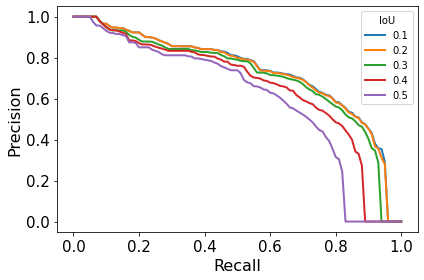

In [5]:
myeval.plot_PRcurve()
plt.tight_layout()
plt.gcf().savefig(os.path.join(cfg.OUTPUT_DIR,'PRCurve_'+dataset_name+'.png'),dpi=dpi)


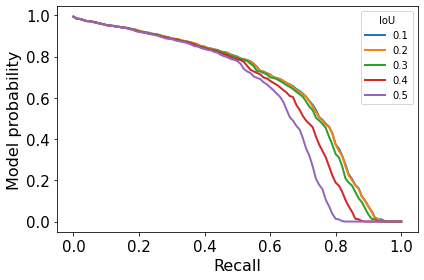

In [6]:
myeval.plot_recall_vs_prob()
plt.tight_layout()
plt.gcf().savefig(os.path.join(cfg.OUTPUT_DIR,'ProbvsRecall_'+dataset_name+'.png'),dpi=dpi)

In [7]:
myeval.build_dfimg()
df = myeval.dfimg

from plain_train_net import CreatePlotsRPD
RPDplt = CreatePlotsRPD(df)

/data/amd-data/cera-rpd/detectron2-rpd/plain_train_net.py:309: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  self.dfpts = self.dfimg.groupby(['ptid','eye'])['gt_instances','gt_pxs','gt_xpxs','dt_instances','dt_pxs','dt_xpxs'].sum()


[0.777 0.812 0.716 0.689 0.623 0.571] [0.885 0.839 0.901 0.836 0.805 0.828] [0.033 0.019 0.022 0.017 0.014 0.013]


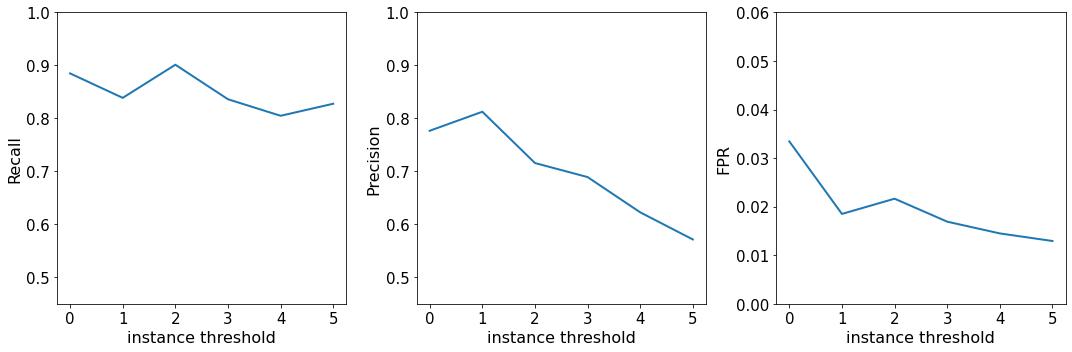

In [8]:
inst = list(range(0,6))
#inst = [4]
pr,rc,fpr = RPDplt.plot_img_level_instance_thresholding(df,inst)
plt.gcf().savefig(os.path.join(cfg.OUTPUT_DIR,'instance_thresh_scan_level_'+dataset_name+'.png'),dpi=dpi)
print(pr,rc,fpr)

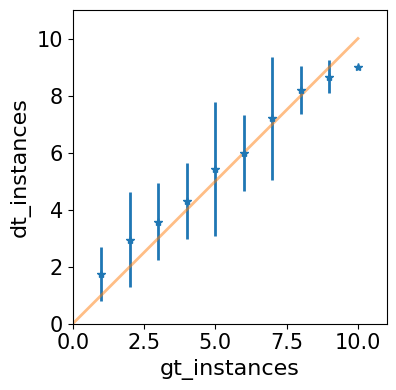

In [9]:
df = myeval.dfimg
fig = RPDplt.gt_vs_dt_instances()
fig.savefig(os.path.join(cfg.OUTPUT_DIR,'gt_dt_instances_'+dataset_name+'.png'),dpi=dpi)

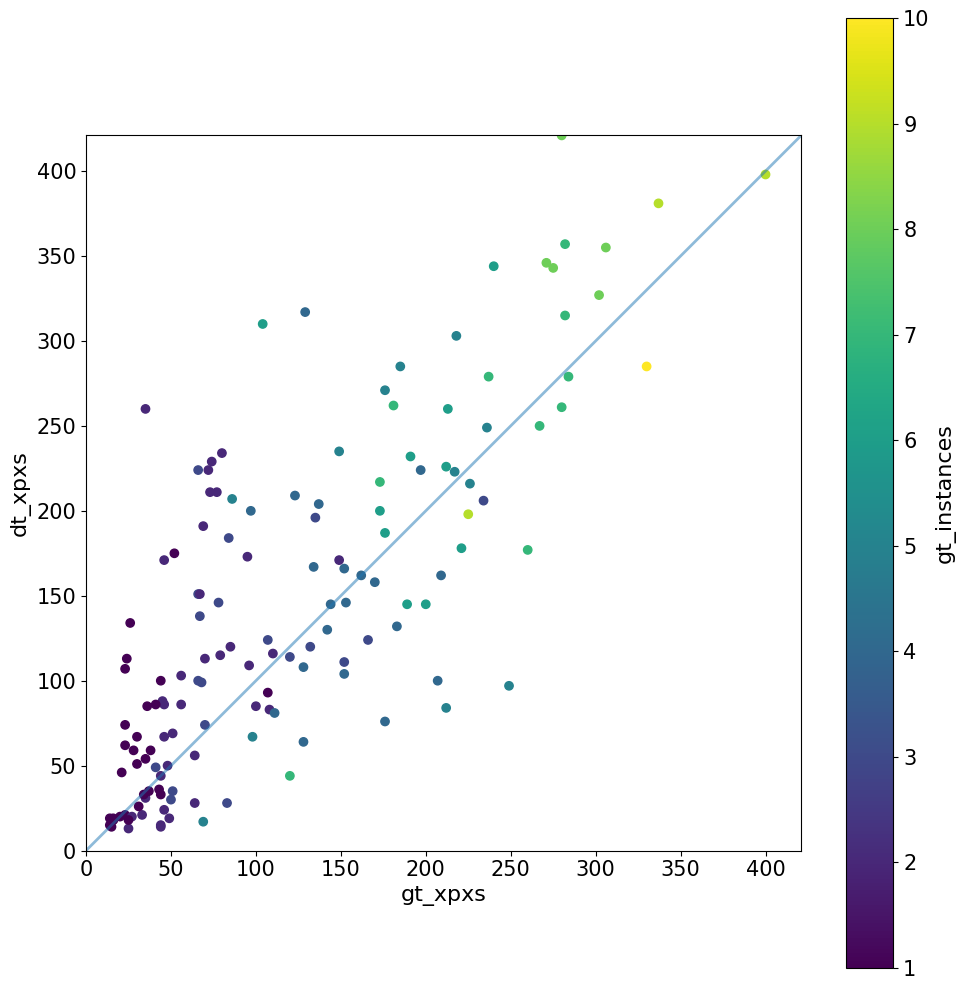

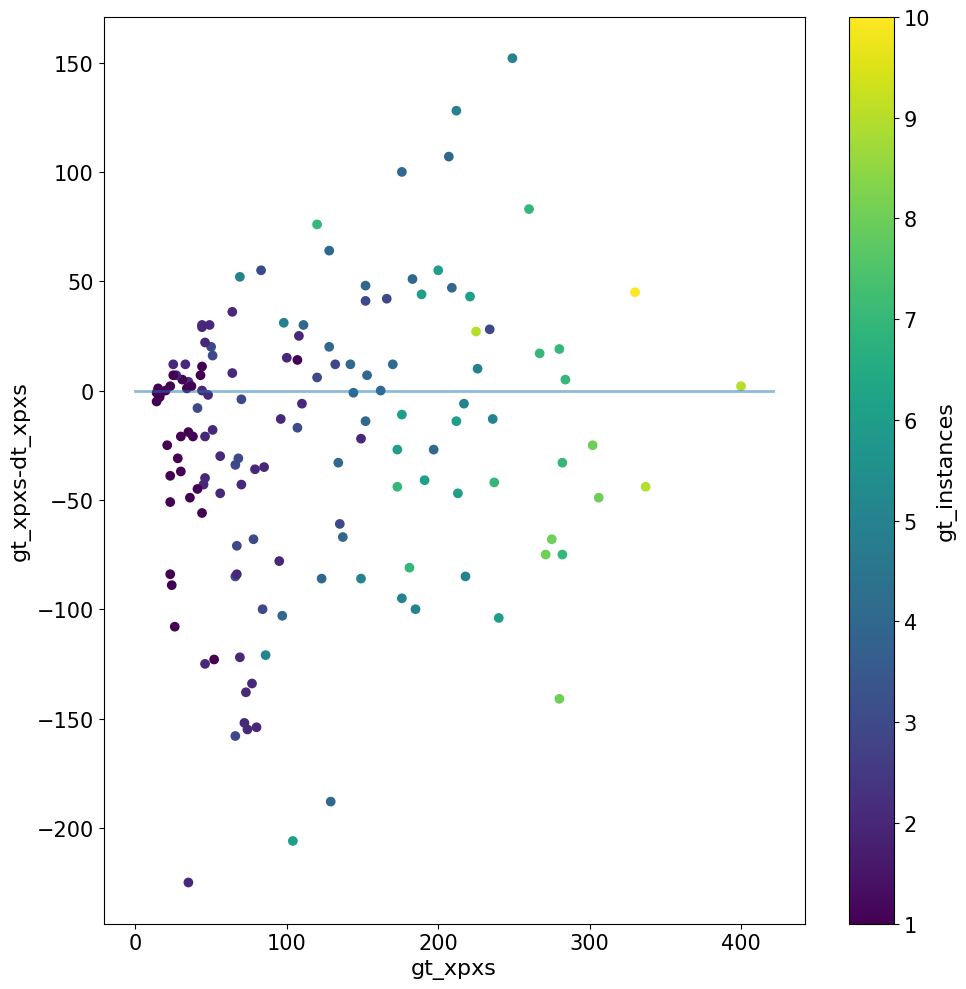

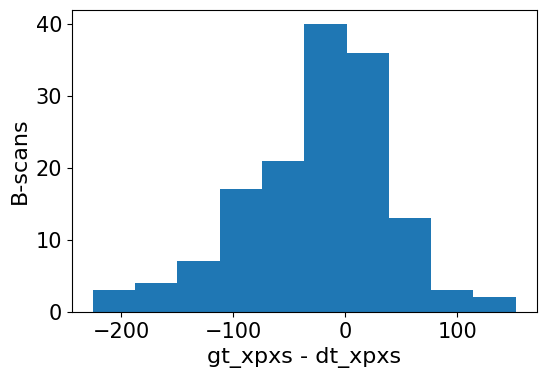

In [10]:
fig1,fig2,fig3 = RPDplt.gt_vs_dt_xpxs()
fig1.savefig(os.path.join(cfg.OUTPUT_DIR,'gt_dt_xpxs_'+dataset_name+'.png'),dpi=dpi)
fig2.savefig(os.path.join(cfg.OUTPUT_DIR,'gt_dt_del_xpxs_'+dataset_name+'.png'),dpi=dpi)

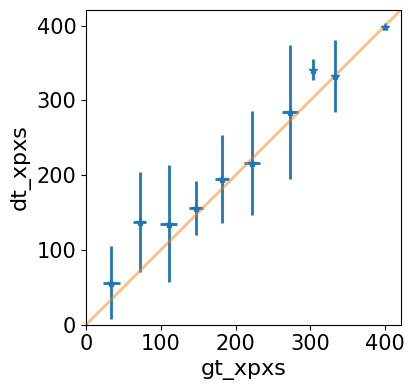

In [11]:
fig = RPDplt.gt_vs_dt_xpxs_mu()
fig.savefig(os.path.join(cfg.OUTPUT_DIR,'gt_dt_mu_xpxs_'+dataset_name+'.png'),dpi=dpi)

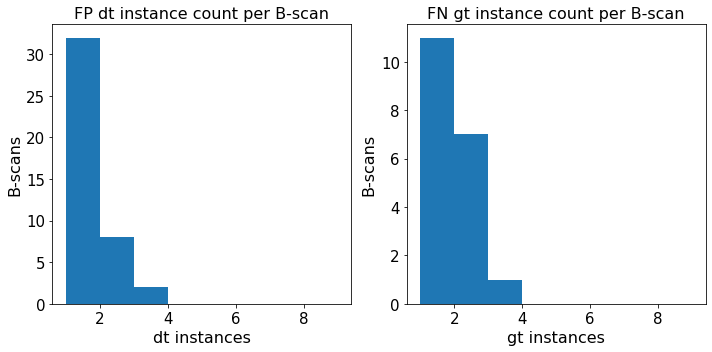

In [12]:
fig = RPDplt.gt_dt_FP_FN_count()
fig.savefig(os.path.join(cfg.OUTPUT_DIR,'gt_dt_FP_FN_count_'+dataset_name+'.png'),dpi=dpi)

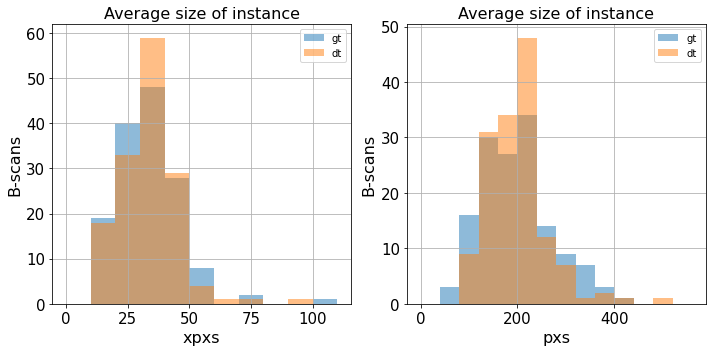

In [13]:
fig = RPDplt.avg_inst_size()
fig.savefig(os.path.join(cfg.OUTPUT_DIR,'avg_inst_size_'+dataset_name+'.png'),dpi=dpi)

In [14]:
RPDplt.dfimg

,gt_instances,gt_pxs,gt_xpxs,dt_instances,dt_pxs,dt_xpxs,ptid,eye,scan
101013_OD_oct-041.png,0.0,0.0,0.0,0.0,0.0,0.0,101013,OD,oct-041
101334_OD_oct-016.png,3.0,382.0,68.0,3.0,578.0,99.0,101334,OD,oct-016
103027_OD_oct-000.png,0.0,0.0,0.0,0.0,0.0,0.0,103027,OD,oct-000
101285_OS_oct-011.png,1.0,135.0,23.0,2.0,432.0,62.0,101285,OS,oct-011
103033_OS_oct-043.png,0.0,0.0,0.0,0.0,0.0,0.0,103033,OS,oct-043
...,...,...,...,...,...,...,...,...,...
101142_OD_oct-012.png,0.0,0.0,0.0,0.0,0.0,0.0,101142,OD,oct-012
101109_OD_oct-007.png,3.0,400.0,66.0,4.0,657.0,100.0,101109,OD,oct-007
105015_OS_oct-021.png,0.0,0.0,0.0,0.0,0.0,0.0,105015,OS,oct-021
102028_OS_oct-007.png,0.0,0.0,0.0,0.0,0.0,0.0,102028,OS,oct-007


In [15]:
df = RPDplt.dfimg
dfpts = RPDplt.dfpts

In [16]:
from plain_train_net import OutputVis
vis = OutputVis(dataset_name,cfg,0.5)
ImgIds = np.abs(df.gt_xpxs-df.dt_xpxs).sort_values(ascending=False).index[0:50].values
#vis.output_to_pdf(ImgIds,os.path.join(cfg.OUTPUT_DIR,'top50_xpxs_err_'+dataset_name+'.pdf'),dfimg =myeval.dfimg )

In [19]:
import pandas as pd
pd.set_option('display.max_rows',500)
RPDplt.dfpts

gt_instances   gt_pxs  gt_xpxs  dt_instances   dt_pxs  dt_xpxs
ptid   eye                                                                
101013 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           3.0    275.0     50.0
101034 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           1.0    197.0     25.0
101051 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           0.0      0.0      0.0
101078 OD           58.0   7280.0    964.0          30.0   3818.0    510.0
101109 OD          153.0  29794.0   5671.0         161.0  35456.0   6496.0
101142 OD           39.0   9214.0   1475.0          46.0   7957.0   1549.0
       OS           51.0  13598.0   2219.0          64.0  13038.0   2258.0
101285 OS           66.0  18079.0   2485.0         102.0  21971.0   3217.0
101334 OD          160.0  27032.0   4873.0         216.0  40474.0   7703.0
102028 OD            0.0      0.0      0.0           4.0    731.0    116.0
       OS            0.0      0.0      0.0           1.0    107.0     18.0
102045 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           0.0      0.0      0.0
103027 OD            0.0      0.0      0.0           2.0    353.0     40.0
       OS            0.0      0.0      0.0           2.0    250.0     29.0
103033 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           0.0      0.0      0.0
104011 OS            7.0   1173.0    206.0           5.0    985.0    160.0
104022 OD            0.0      0.0      0.0           1.0    153.0     18.0
       OS            0.0      0.0      0.0           0.0      0.0      0.0
104060 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           1.0    141.0     25.0
104064 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           0.0      0.0      0.0
105015 OD            0.0      0.0      0.0           0.0      0.0      0.0
       OS            0.0      0.0      0.0           0.0      0.0      0.0

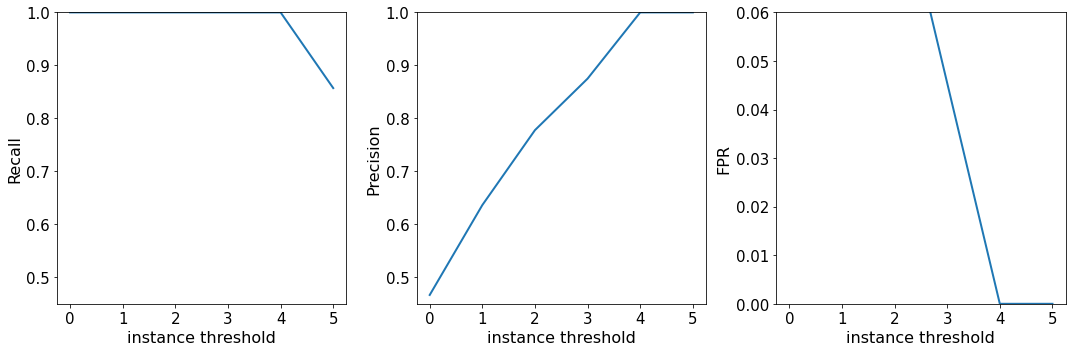

In [20]:
inst = list(range(0,6))
#inst = [4]
pr,rc,fpr = RPDplt.plot_img_level_instance_thresholding(dfpts,inst)

In [20]:
def hover(hover_color="#add8e6"):
    return dict(selector="tbody tr:hover",
            props=[("background-color", "%s" % hover_color)])

styles = [
    #table properties
    dict(selector=" ", 
         props=[("margin","0"),
                ("font-family",'"Helvetica", "Arial", sans-serif'),
                ("border-collapse", "collapse"),
                ("border","none"),
                ("border", "2px solid #ccf")
                   ]),

#     #header color - optional
#     dict(selector="thead", 
#          props=[("background-color","#cc8484")
#                ]),

    #background shading
    dict(selector="tbody tr:nth-child(even)",
         props=[("background-color", "#fff")]),
    dict(selector="tbody tr:nth-child(odd)",
         props=[("background-color", "#eee")]),

    #cell spacing
    dict(selector="td", 
         props=[("padding", ".5em"),("text-align","center")]),

    #header cell properties
    dict(selector="th", 
         props=[("font-size", "125%"),
                ("text-align", "center")]),

    #caption placement
    dict(selector="caption", 
         props=[("caption-side", "bottom")]),

    #render hover last to override background-color
    hover()
]


In [21]:
html_str = dfpts.style.format('{:.0f}').set_table_styles(styles).render()
html_file = open(os.path.join(cfg.OUTPUT_DIR,'dfpts_'+dataset_name+'.html'),'w')
html_file.write(html_str)
html_file.close()

In [22]:
dfpts.style.format('{:.0f}').set_table_styles(styles).set_table_attributes('style="font-size: 17px"')

In [23]:
d1 = {'dataset': 'fold1',
 'precision': 0.843,
 'recall': 0.780,
 'fpr': 0.047,
 'iou': 0.200,
 'probability': 0.500}

d2 = {'dataset': 'fold2',
 'precision': 0.645,
 'recall': 0.770,
 'fpr': 0.034,
 'iou': 0.200,
 'probability': 0.500}

d3 = {'dataset': 'fold3',
 'precision': 0.851,
 'recall': 0.620,
 'fpr': 0.010,
 'iou': 0.200,
 'probability': 0.500}

d4 = {'dataset': 'fold4',
 'precision': 0.629,
 'recall': 0.750,
 'fpr': 0.033,
 'iou': 0.200,
 'probability': 0.500}

d5 = {'dataset': 'fold5',
 'precision': 0.545,
 'recall': 0.820,
 'fpr': 0.042,
 'iou': 0.200,
 'probability': 0.500}


dfr = pd.DataFrame([d1, d2, d3, d4, d5])
dfr.style.format('{:3}').set_table_styles(styles).set_table_attributes('style="font-size: 17px"')

,dataset,precision,recall,fpr,iou,probability
0,fold1,0.843,0.78,0.047,0.2,0.5
1,fold2,0.645,0.77,0.034,0.2,0.5
2,fold3,0.851,0.62,0.01,0.2,0.5
3,fold4,0.629,0.75,0.033,0.2,0.5
4,fold5,0.545,0.82,0.042,0.2,0.5
